# Jupyter Notebook Assignment: Heartbeat Classification with RNN, LSTM, and GRU

## Title: Heartbeat Classification using Sequence Models

### Objective:
In this assignment, you will build, train, and evaluate three different sequence models (RNN, LSTM, GRU) to classify heartbeats based on ECG data. You will compare their performance using metrics such as AUC, F1-score, and accuracy. Additionally, you will explore the data and visualize the results for better understanding.


1. **Dataset Overview:**
   - The dataset contains heartbeat signals derived from two well-known datasets: the MIT-BIH Arrhythmia Dataset and PhysioNet's MIT-BIH Arrhythmia Database.
   - Each row in the dataset is a time series corresponding to one heartbeat, and the signals represent electrocardiogram (ECG) waveforms.
   - The dataset is preprocessed and segmented, with each segment corresponding to a heartbeat. The last column represents the label (5 classes):
     - **'N': 0** - Normal heartbeat
     - **'S': 1** - Supraventricular premature beat
     - **'V': 2** - Premature ventricular contraction
     - **'F': 3** - Fusion of ventricular and normal beat
     - **'Q': 4** - Unclassifiable beat
   - Number of Samples: **109,446**
   - Sampling Frequency: **125 Hz**
   - Training data: `mitbih_train.csv`
   - Testing data: `mitbih_test.csv`
   - Data Source: PhysioNet's MIT-BIH Arrhythmia Dataset

   **Background:**
   - The MIT-BIH Arrhythmia Database includes 48 half-hour excerpts of two-channel ambulatory ECG recordings from 47 subjects, recorded between 1975 and 1979. These recordings were selected to include less common but clinically significant arrhythmias.
   - Each recording was digitized at 360 samples per second per channel, annotated independently by two or more cardiologists.

2. **Assignment Tasks:**

    * When working on graded functions, please remember to only modify the code that is between the
    ```Python
    #### START CODE HERE
    ```
    and
    ```Python
    #### END CODE HERE
    ```

   #### Task 1: Data Exploration
   - Load the data and explore its structure.
   - Plot a few ECG signals for visualization.
   - Check the distribution of classes and identify any imbalance.

   #### Task 2: Model Implementation
   - Implement three sequence models: RNN, LSTM, and GRU.
   - Define the architecture for each model.
   - Train each model on the training dataset.

   #### Task 3: Performance Evaluation
   - Evaluate the performance of each model using:
     - AUC (Area Under the Curve)
     - F1-score
     - Accuracy
   - Generate a confusion matrix for each model.
   - Plot training and testing loss, AUC, F1-score, and accuracy for each epoch.

   #### Task 4: Results Comparison
   - Compare the performance of the three models using tables and plots.
   - Discuss which model performed the best and why.

   #### Task 5: Visualization and Insights
   - Visualize key insights such as class-wise performance, confusion matrix heatmaps, and metric trends over epochs.

3. **Deliverables:**
   - Submit a completed Jupyter Notebook with:
     - Code for all tasks.
     - Plots and visualizations.
     - A short discussion on the results.

4. **Grading Criteria:**
   - Correctness and completeness of the implementation.
   - Quality of visualizations.
   - Depth of analysis in the discussion.

5. **Tips:**
   - Use GPU for faster training.
   - Document your code with comments for better readability.
   - Use libraries like `matplotlib` and `seaborn` for visualizations.

---

## Assignments:

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("-------- Checking Imports ---------")
print("All imports are successsful!")
print(sys.executable)
print()

-------- Checking Imports ---------
All imports are successsful!
/nas/longleaf/home/fangliu/.conda/envs/sequence_modeling/bin/python



In [3]:

print("-------- Checking GPU -------------")
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
print("name:", torch.cuda.get_device_name(0))
print("capability:", torch.cuda.get_device_capability(0))
print("memory GB (approx):", torch.cuda.get_device_properties(0).total_memory/1024**3)
print()

-------- Checking GPU -------------
cuda available: True
device count: 1
name: NVIDIA A100-PCIE-40GB
capability: (8, 0)
memory GB (approx): 39.4935302734375



In [4]:
# Load the data
def load_data(train_path, test_path):
    
    #### START CODE HERE
    # Load train and test datasets using pandas
    # Note: Each row represents a time series with 187 time steps, each having one feature value, and the last column contains the label indicating 1 of 5 classes

    train_df = pd.read_csv(train_path, header=None)
    test_df = pd.read_csv(test_path, header=None)

    X_train = train_df.iloc[:, :-1].values #extract time-series values; shape(#samples, 187)
    y_train = train_df.iloc[:, -1].values  #extract class label from last column 

    X_test = test_df.iloc[:, :-1].values #extract time-series values
    y_test = test_df.iloc[:, -1].values  #extract class label from last column 
    
    #### END CODE HERE
    
    return X_train, y_train, X_test, y_test


In [5]:
# Dataset class
class HeartbeatDataset(Dataset):
    def __init__(self, X, y):
        
        ####START CODE HERE
        # Instruction: Replace this with a PyTorch Dataset class implementation.
        
        # Convert features to float tensor (unsqueeze adds a dimension of size 1 at the last position to meet pytorch requirement)
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) #PyTorch LSTM expects (batch_size=N, sequence_length=187, input_size=1)
        
        # Convert labels to long tensor (required for CrossEntropyLoss)
        self.y = torch.tensor(y, dtype=torch.long)
        
        #### END CODE HERE

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# Data exploration
def explore_data(X_train, y_train):
    # Check data structure
    print("Shape of X_train:", X_train.shape) #should be (N, 187)
    print("Shape of y_train:", y_train.shape) #should be (N,)

    # Plot a few ECG signals
    plt.figure(figsize=(12, 6))
    for i in range(5):
        ####START CODE HERE
        # Instruction: Replace this with your own implementation to explore and visualize the data.
        # I want to visualize one ECG example for EACH class

        #get unique classes
        unique_classes = np.unique(y_train)
        #pick one sample from each class and plot
        cls = unique_classes[i]
        idx = np.where(y_train == cls)[0][0]
        plt.plot(X_train[idx], label=f"Class {cls}")
    
        #### END CODE HERE
    plt.title("Sample ECG Signals")
    plt.xlabel("Time Step")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.savefig("sample_ecg_signals.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Check class distribution
    class_counts = pd.Series(y_train).value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.savefig("class_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()

In [7]:
# 1) RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        
        ####START CODE HERE
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #rnn layer
        self.rnn = nn.RNN(
            input_size=input_size, #will be 1 since we have one feature per time step
            hidden_size=hidden_size, #size of the hidden state vector 
            num_layers=num_layers, #number of stacked RNN layers
            batch_first=True #tensors in order of (batch, sequence length, and features)
        )
        self.dropout = nn.Dropout(0.2)
        #fully connected layer that map last hidden state to class logits
        self.fc = nn.Linear(hidden_size, num_classes)
        #### END CODE HERE

    def forward(self, x):
        ####START CODE HERE
        #shape for input x is (batch, seq_length, input size) -> (B, 187, 1)
        
        # initialize hidden state h0: [num_layers, batch, hidden_size]
        # RNN keeps one hidden state per layer per sample.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        # out: [batch, seq_len, hidden_size]
        out, _ = self.rnn(x, h0)

        #use output at last time step since it summarizes the entire ECG beat [batch, hidden_size]
        out = out[:, -1, :]
        out = self.dropout(out)
        #class logits [batch, num_classes]
        #output is the logit for each of the class, where the highest value = predicted class
        out = self.fc(out)
        #### END CODE HERE
        return out


In [8]:
# 2) LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        ####START CODE HERE
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        #### END CODE HERE

    def forward(self, x):
        ####START CODE HERE
        out, (hn, cn) = self.lstm(x) # [batch, seqlen, hidden], ([num_layers, batch, hidden], [num_layers, batch, hidden])
        out = out[:, -1, :] # [batch, hidden]
        out = self.dropout(out)
        out = self.fc(out) # [batch, num_class]
        #### END CODE HERE
        return out

In [9]:
# 3) GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        ####START CODE HERE
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)        
        #### END CODE HERE

    def forward(self, x):
        ####START CODE HERE
        out, hn = self.gru(x) # [batch, seqlen, hidden], [num_layers, batch, hidden]
        out = out[:, -1, :] # [batch, hidden]
        out = self.dropout(out)
        out = self.fc(out) # [batch, num_class]
        #### END CODE HERE
        return out

In [24]:
# Training and evaluation functions
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    #for X, y in tqdm(train_loader): #to show batch progress bar
    for X, y in train_loader:
        ####START CODE HERE
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()         #clear old gradients
        outputs= model(X)             #forward pass
        #check how far the prediction is from the true ECG labels(softmax to convert logit to prob -> negative log likelihood -> average across batch)
        loss = criterion(outputs, y)  
        loss.backward()               #compute gradient 
        optimizer.step()              #update parameters
                
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())
        #### END CODE HERE
    
    auc = roc_auc_score(pd.get_dummies(all_targets), pd.get_dummies(all_preds), multi_class='ovr')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(train_loader), auc, f1, acc


def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        #for X, y in tqdm(data_loader): #to show progress bar
        for X, y in data_loader:

            ####START CODE HERE
            X, y = X.to(device), y.to(device)

            outputs= model(X)
            loss = criterion(outputs, y)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            #### END CODE HERE
    
    auc = roc_auc_score(pd.get_dummies(all_targets), pd.get_dummies(all_preds), multi_class='ovr')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(data_loader), auc, f1, acc

def plot_metrics(train_metrics, test_metrics, epochs):
    plt.figure(figsize=(12, 6))
    for metric_name in train_metrics.keys():
        plt.plot(range(epochs), train_metrics[metric_name], label=f"Train {metric_name}")
        plt.plot(range(epochs), test_metrics[metric_name], label=f"Test {metric_name}", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


## Begin analysis

In [25]:
train_path = "mitbih_train.csv"
test_path = "mitbih_test.csv"

# Load data
X_train, y_train, X_test, y_test = load_data(train_path, test_path)

Shape of X_train: (87554, 187)
Shape of y_train: (87554,)


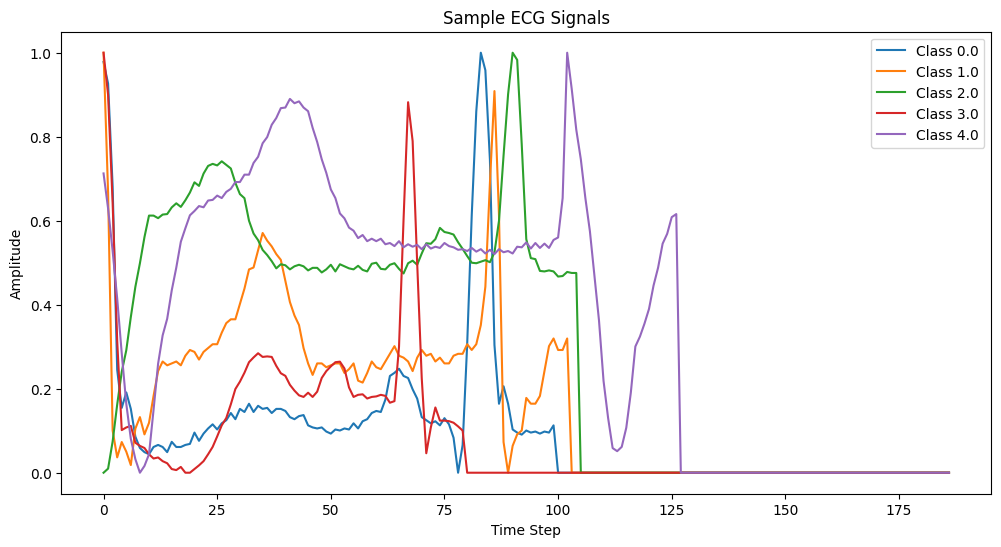

/tmp/fangliu/32126196/g1416ood07.ll.unc.edu/ipykernel_1107105/2324345153.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


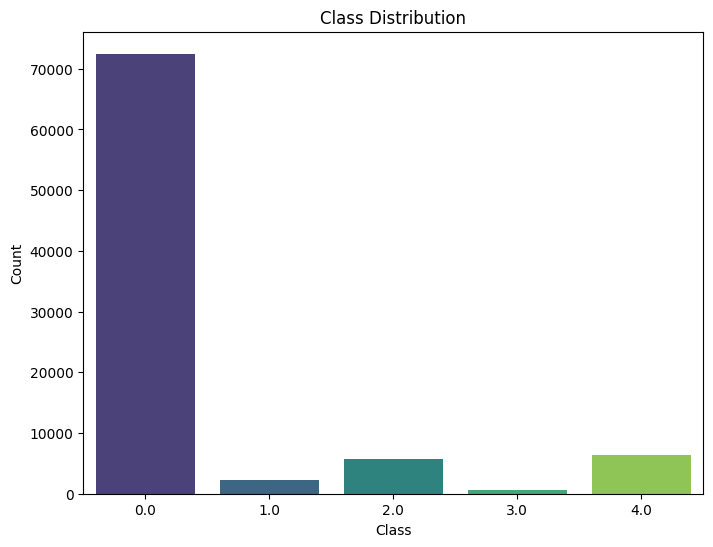

In [26]:
# Explore data
explore_data(X_train, y_train)
#explore_data(X_test, y_test)

In [27]:
#train_dataset = HeartbeatDataset(X_train[:1000], y_train[:1000])
train_dataset = HeartbeatDataset(X_train, y_train)
test_dataset = HeartbeatDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#print(len(train_loader)) #87554/64 = 1369 forward/backward passes; one epoch approx. 1359 iterations for training
#print(len(test_loader)) #21892/64 = 343; one epoch approx 343 iterations for testing

####START CODE HERE
input_size = 1
hidden_size = 64 #128
num_layers = 2
num_classes = 5
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#### END CODE HERE

models = {
    "RNN": RNNModel(input_size, hidden_size, num_layers, num_classes).to(device),
    "LSTM": LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device),
    "GRU": GRUModel(input_size, hidden_size, num_layers, num_classes).to(device)
}

criterion = nn.CrossEntropyLoss()
results = {}

cuda


Training RNN...
Epoch 1/30: Train Loss: 0.6646, Test Loss: 0.6563, Test AUC: 0.5037, Test F1: 0.7517, Test Acc: 0.8282
Epoch 2/30: Train Loss: 0.6539, Test Loss: 0.6546, Test AUC: 0.5025, Test F1: 0.7501, Test Acc: 0.8277
Epoch 3/30: Train Loss: 0.6564, Test Loss: 0.6557, Test AUC: 0.5263, Test F1: 0.7538, Test Acc: 0.8279
Epoch 4/30: Train Loss: 0.6562, Test Loss: 0.6570, Test AUC: 0.5018, Test F1: 0.7499, Test Acc: 0.8277
Epoch 5/30: Train Loss: 0.6526, Test Loss: 0.6560, Test AUC: 0.5149, Test F1: 0.7524, Test Acc: 0.8283
Epoch 6/30: Train Loss: 0.6548, Test Loss: 0.6578, Test AUC: 0.5044, Test F1: 0.7505, Test Acc: 0.8277
Epoch 7/30: Train Loss: 0.6515, Test Loss: 0.6533, Test AUC: 0.5048, Test F1: 0.7506, Test Acc: 0.8277
Epoch 8/30: Train Loss: 0.6559, Test Loss: 0.6539, Test AUC: 0.5006, Test F1: 0.7497, Test Acc: 0.8276
Epoch 9/30: Train Loss: 0.6536, Test Loss: 0.6538, Test AUC: 0.5025, Test F1: 0.7501, Test Acc: 0.8277
Epoch 10/30: Train Loss: 0.6600, Test Loss: 0.6531, Test 

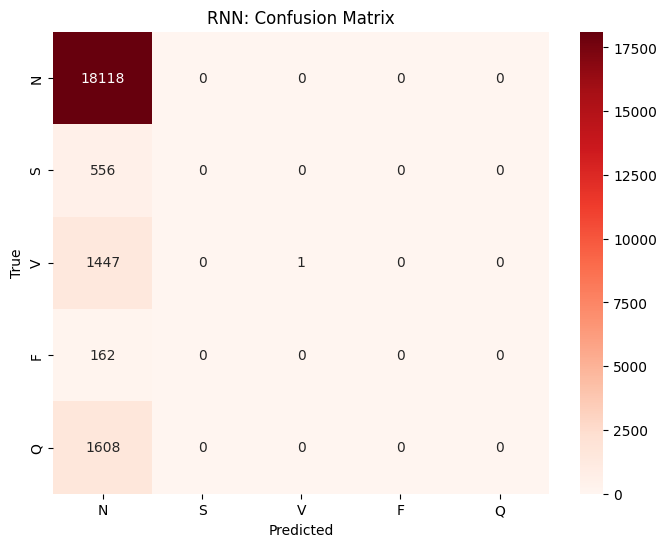

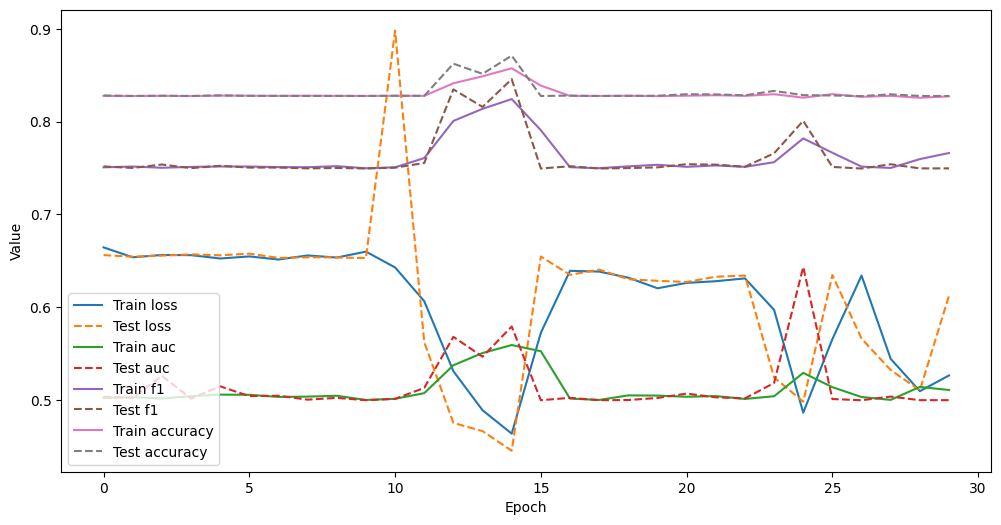

Training LSTM...
Epoch 1/30: Train Loss: 0.6738, Test Loss: 0.6484, Test AUC: 0.5000, Test F1: 0.7495, Test Acc: 0.8276
Epoch 2/30: Train Loss: 0.6568, Test Loss: 0.6239, Test AUC: 0.5291, Test F1: 0.7542, Test Acc: 0.8260
Epoch 3/30: Train Loss: 0.4331, Test Loss: 0.3444, Test AUC: 0.6323, Test F1: 0.8991, Test Acc: 0.9178
Epoch 4/30: Train Loss: 0.3061, Test Loss: 0.2707, Test AUC: 0.6643, Test F1: 0.9139, Test Acc: 0.9286
Epoch 5/30: Train Loss: 0.2702, Test Loss: 0.2432, Test AUC: 0.6756, Test F1: 0.9190, Test Acc: 0.9327
Epoch 6/30: Train Loss: 0.2418, Test Loss: 0.2140, Test AUC: 0.7207, Test F1: 0.9369, Test Acc: 0.9446
Epoch 7/30: Train Loss: 0.2136, Test Loss: 0.1947, Test AUC: 0.7347, Test F1: 0.9419, Test Acc: 0.9487
Epoch 8/30: Train Loss: 0.1891, Test Loss: 0.1869, Test AUC: 0.8242, Test F1: 0.9484, Test Acc: 0.9520
Epoch 9/30: Train Loss: 0.1705, Test Loss: 0.1548, Test AUC: 0.8691, Test F1: 0.9576, Test Acc: 0.9596
Epoch 10/30: Train Loss: 0.1538, Test Loss: 0.1467, Test

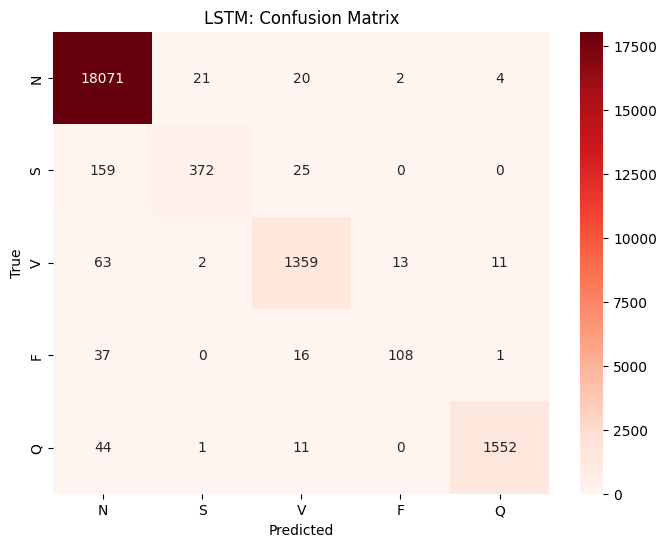

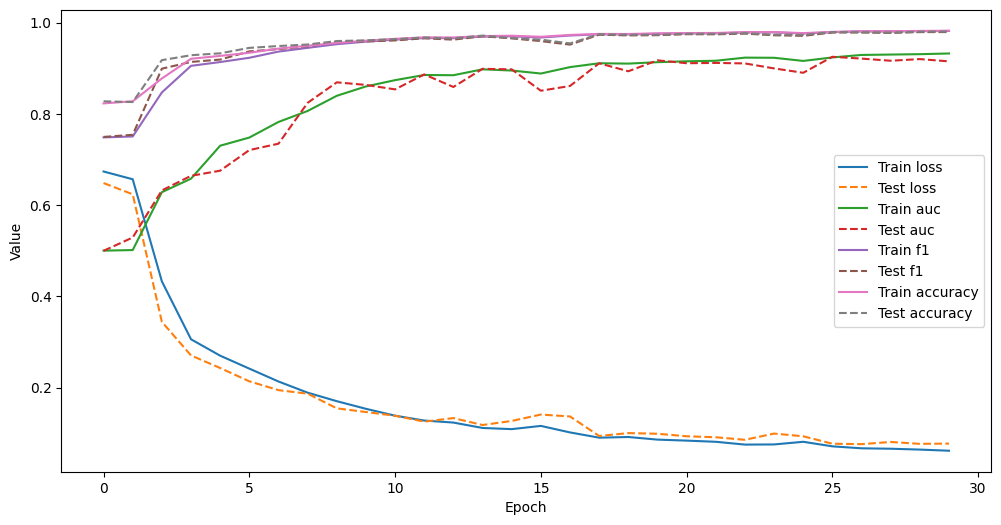

Training GRU...
Epoch 1/30: Train Loss: 0.4558, Test Loss: 0.2825, Test AUC: 0.6592, Test F1: 0.9109, Test Acc: 0.9280
Epoch 2/30: Train Loss: 0.2328, Test Loss: 0.1943, Test AUC: 0.7993, Test F1: 0.9457, Test Acc: 0.9514
Epoch 3/30: Train Loss: 0.1725, Test Loss: 0.1537, Test AUC: 0.8241, Test F1: 0.9553, Test Acc: 0.9601
Epoch 4/30: Train Loss: 0.1464, Test Loss: 0.1415, Test AUC: 0.8353, Test F1: 0.9576, Test Acc: 0.9614
Epoch 5/30: Train Loss: 0.1305, Test Loss: 0.1238, Test AUC: 0.8686, Test F1: 0.9649, Test Acc: 0.9674
Epoch 6/30: Train Loss: 0.1187, Test Loss: 0.1223, Test AUC: 0.8842, Test F1: 0.9666, Test Acc: 0.9687
Epoch 7/30: Train Loss: 0.1066, Test Loss: 0.1114, Test AUC: 0.8961, Test F1: 0.9679, Test Acc: 0.9691
Epoch 8/30: Train Loss: 0.0985, Test Loss: 0.1029, Test AUC: 0.9037, Test F1: 0.9705, Test Acc: 0.9717
Epoch 9/30: Train Loss: 0.0922, Test Loss: 0.0961, Test AUC: 0.8999, Test F1: 0.9732, Test Acc: 0.9748
Epoch 10/30: Train Loss: 0.0858, Test Loss: 0.0893, Test 

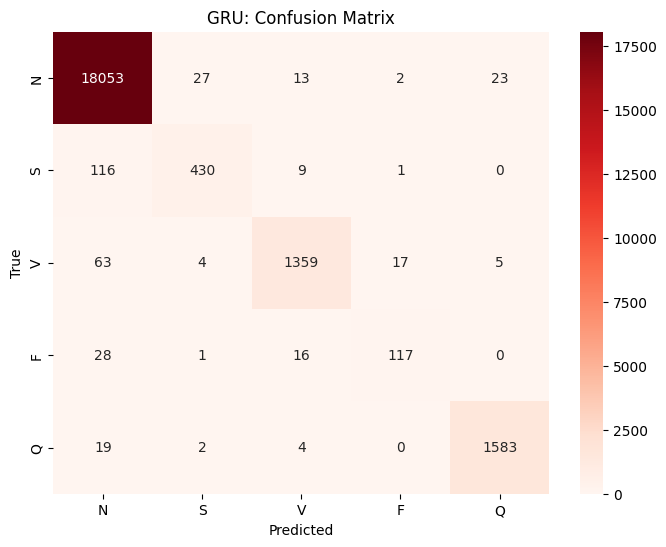

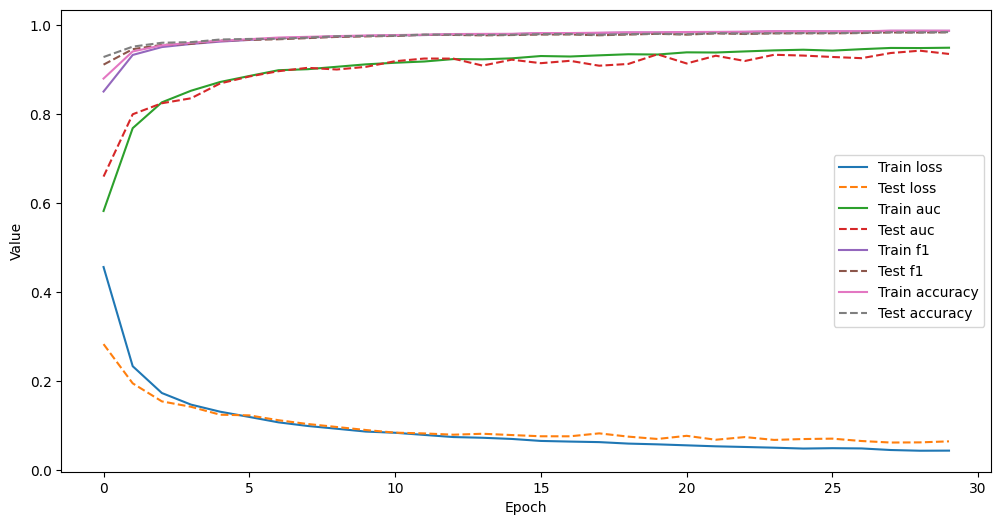

In [28]:

for model_name, model in models.items():
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_metrics = {"loss": [], "auc": [], "f1": [], "accuracy": []}
    test_metrics = {"loss": [], "auc": [], "f1": [], "accuracy": []}

    for epoch in range(num_epochs):
        train_loss, train_auc, train_f1, train_acc = train_model(model, criterion, optimizer, train_loader, device)
        train_metrics["loss"].append(train_loss)
        train_metrics["auc"].append(train_auc)
        train_metrics["f1"].append(train_f1)
        train_metrics["accuracy"].append(train_acc)

        test_loss, test_auc, test_f1, test_acc = evaluate_model(model, criterion, test_loader, device)
        test_metrics["loss"].append(test_loss)
        test_metrics["auc"].append(test_auc)
        test_metrics["f1"].append(test_f1)
        test_metrics["accuracy"].append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}, Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

    results[model_name] = (train_metrics, test_metrics)

    # Confusion Matrix
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    ####START CODE HERE
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    class_names = ['N', 'S', 'V', 'F', 'Q']
    sns.heatmap(
        cm, 
        annot=True, #write #s inside cell
        fmt='d', 
        cmap='Reds', 
        xticklabels=class_names, #predicted class labels
        yticklabels=class_names  #true class labels
    )
    plt.title(f'{model_name}: Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_name}_confusion_matrix', dpi=150, bbox_inches='tight')
    plt.show()
    ### END CODE HERE

    plot_metrics(train_metrics, test_metrics, num_epochs)

## Discussion of Results

Let's summarize the findings above by comparing RNN, LSTM, and GRU performance on the MIT-BIH ECG Classification (30 Epochs).

In [37]:
## create a comparison table for the final metrics (from last epoch)
comparison_data = []

for model_name, (train_metrics, test_metrics) in results.items():
    comparison_data.append({
        "Model": model_name,
        "Final Train Loss": train_metrics["loss"][-1],
        "Final Test Loss": test_metrics["loss"][-1],
        "Final Test AUC": test_metrics["auc"][-1],
        "Final Test F1": test_metrics["f1"][-1],
        "Final Test Accuracy": test_metrics["accuracy"][-1]
    })
    
comparison_df.style.format({
    "Final Train Loss": "{:.4f}",
    "Final Test Loss": "{:.4f}",
    "Final Test AUC": "{:.4f}",
    "Final Test F1": "{:.4f}",
    "Final Test Accuracy": "{:.4f}"
})

,Model,Final Train Loss,Final Test Loss,Final Test AUC,Final Test F1,Final Test Accuracy
0,RNN,0.5266,0.6126,0.5001,0.7497,0.8277
1,LSTM,0.0619,0.0775,0.9150,0.9794,0.9804
2,GRU,0.0430,0.0639,0.9349,0.9835,0.9840


From the results above, we see substantial performance differences across the three sequence models. The vanilla RNN performs significantly worse than the gated architectures, with lower test accuracy (0.8277) and near-random AUC (0.5001). Note that the RNN confusion matrix show almost all samples was classified as Normal, which contributed to the seemingly good test accuracy of 80%+. This suggests that the basic RNN struggles to capture long-range temporal dependencies in the ECG signals, likely due to *vanishing gradient* issues.

Both LSTM and GRU achieve excellent performance, with test accuracies above 0.98 and very high F1 scores (>0.97). The strong AUC values (0.9150 for LSTM and 0.9349 for GRU) indicate robust class separation across all five heartbeat types. From the LSTM and GRU confusion matrixes, we see there is strong diagonal dominance with the non-diagnonal errors small relative to the total class counts. Some minority classes are occasionally misclassified as Normal, reflecting class imbalance and morphological similarity between arrhythmia types. Between the two gated models, GRU slightly outperforms LSTM, achieving the highest test accuracy (0.9840) and AUC (0.9349) while also maintaining lower test loss. This suggests that GRU provides an effective balance between model complexity and learning capacity for this task. 

Overall, the results confirm that gated recurrent architectures (LSTM/GRU) are substantially better suited than vanilla RNNs for ECG sequence classification.
